In [45]:
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import os
fontpath = os.path.expanduser('~/.local/share/fonts/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': prop.get_name(),
    'text.usetex': True
}

mpl.rcParams.update(params)

import sys
# Local Modules
sys.path.insert(0, os.path.abspath('/scratch/horta/youtube_dataset/'))
from helpers.plot import set_size

import warnings
warnings.filterwarnings('ignore')

## Loads data and preprocess datetime fields

In [6]:
df_sb_f = pd.read_csv("/dlabdata1/youtube_large/df_timeseries_en.tsv.gz", compression="infer", sep="\t")
df_vd_f = pd.read_feather("/dlabdata1/youtube_large/yt_metadata_helper.feather")
df_ch_f = pd.read_csv("/dlabdata1/youtube_large/df_channels_en.tsv.gz", compression="infer", sep="\t")
df_vd_f["dummmy"] = 1
df_sb_f["datetime"] = pd.to_datetime(df_sb_f["datetime"])
df_ch_f["join_date"] = pd.to_datetime(df_ch_f["join_date"])

In [7]:
num_comments = pd.read_csv("/dlabdata1/youtube_large/num_comments.tsv.gz", compression="infer", sep="\t")
num_comments_authors = pd.read_csv("/dlabdata1/youtube_large/num_comments_authors.tsv.gz", compression="infer", 
                                   sep="\t")

## 1. Video and channel statistics

In [12]:
# gets videos_yt count
df_vd_vid_count = dict(df_vd_f.groupby("channel_id").count().display_id) 
df_ch_f["videos_yt"] = df_ch_f["channel"].apply(lambda x: df_vd_vid_count[x])

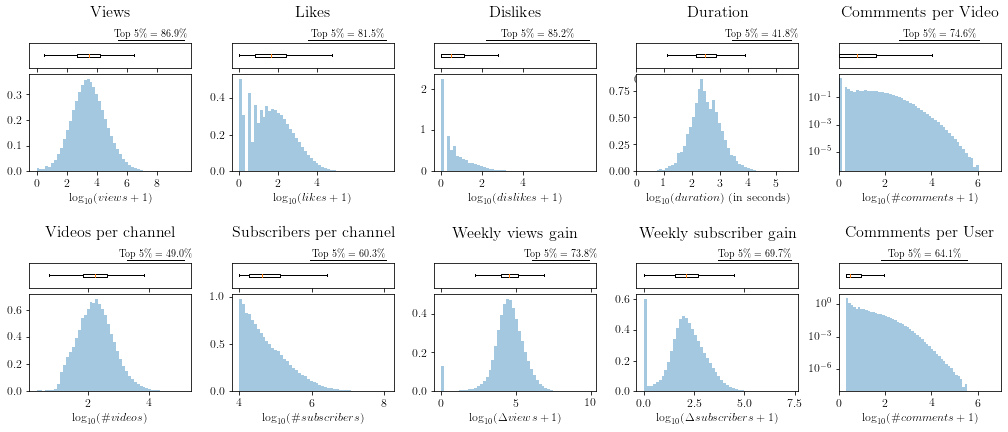

In [50]:
import matplotlib.transforms as transforms

fig, axs = plt.subplots(5, 5, figsize=(14, 6), 
                         gridspec_kw={"wspace": 0.25, "hspace": 0.1, 
                                      "height_ratios": [0.2, 0.8, 0.65, 0.2, 0.8]})
N = len(df_vd_f)#136470
    
kwargs = {'cumulative': False}

def plot_mean(ax, vals):
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    quant95 = vals.quantile(0.95)
    quant100 = vals.quantile(1)
    plt.plot([np.log10(quant95), np.log10(quant100)], [1.15, 1.15], 
             lw=1, color = "black", transform=trans, clip_on=False)
    top5p = vals[vals >= quant95].sum() / sum(vals)
    plt.text((np.log10(quant95) + np.log10(quant100)) / 2, 1.25, 
             "Top $5\% = {}\%$".format(round(top5p*100,1)), ha="center",
        transform=trans, size=10)

def plot_box(ax, vals):
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.boxplot(np.log10(vals), showfliers=False, vert=False)
    ax.set_yticks([])
    
# Video stuff
df_tmp = df_vd_f.sample(N)
titles = ["Views", "Likes", "Dislikes", "Duration"]
cols = ["view_count", "like_count", "dislike_count", "duration"]
xlabels = [r'$\log_{10}(views + 1)$', r'$\log_{10}(likes + 1)$',
          r'$\log_{10}(dislikes + 1)$', r'$\log_{10}(duration)$ (in seconds)']
xticks = [[0, 2, 4, 6, 8], [0, 2, 4], [0, 2, 4], [0, 1, 2, 3, 4, 5]]

for idx, title in enumerate(titles):
    ax = axs[1, idx]
    sns.distplot(np.log10(df_tmp[cols[idx]] + 1), hist_kws=kwargs, kde=False, kde_kws=kwargs, ax=ax, norm_hist=True)
    ax.set_xlabel(xlabels[idx])
    ax.set_xticks(xticks[idx])
    xtickstmp = ax.get_xticks()
    xlimtmp = ax.get_xlim()
    
    ax = axs[0, idx]
    ax.set_title(title, pad=25, size=16)
    vals = df_tmp[cols[idx]].dropna() + 1
    plot_box(ax, vals)
    plot_mean(ax, vals)
    ax.set_xticks(xtickstmp)
    ax.set_xlim(xlimtmp)
    
# Channel stuff
df_tmp = df_ch_f
titles = ["Videos per channel", "Subscribers per channel"]
cols = ["videos_yt", "subscribers_cc"]
xlabels = [r'$\log_{10}(\#videos)$', 
           r'$\log_{10}(\#subscribers)$']

for idx, title in enumerate(titles):
    
    ax = axs[4, idx]
    sns.distplot(np.log10(df_tmp[cols[idx]] + 1), hist_kws=kwargs, kde=False, kde_kws=kwargs, ax=ax, norm_hist=True)
    ax.set_xlabel(xlabels[idx])
    xtickstmp = ax.get_xticks()
    xlimtmp = ax.get_xlim()
    
    ax = axs[3, idx]
    ax.set_title(title, pad=25, size=16)
    vals = df_tmp[cols[idx]].dropna() + 1
    plot_box(ax, vals)
    plot_mean(ax, vals)
    ax.set_xticks(xtickstmp)
    ax.set_xlim(xlimtmp)

N = len(df_sb_f)#136470

# Time series stuff
df_tmp = df_sb_f.sample(N)
titles = ["Weekly views gain", "Weekly subscriber gain"]
cols = ["delta_views", "delta_subs"]
xlabels = [r'$\log_{10}(\Delta views + 1)$', 
           r'$\log_{10}(\Delta subscribers + 1)$']

for idx, title in enumerate(titles):
    ax = axs[4, idx+2]
    sns.distplot(np.log10(df_tmp[cols[idx]] + 1), hist_kws=kwargs, 
                 kde=False, kde_kws=kwargs, ax=ax, norm_hist=True)
    ax.set_xlabel(xlabels[idx])
    xtickstmp = ax.get_xticks()
    xlimtmp = ax.get_xlim()
    
    ax = axs[3, idx+2]
    ax.set_title(title, pad=25, size=16)
    vals = df_tmp[cols[idx]].dropna() + 1
    plot_box(ax, vals)
    plot_mean(ax, vals)
    ax.set_xticks(xtickstmp)
    ax.set_xlim(xlimtmp)
    
for ax in axs[2, :]:
    ax.set_visible(False)


for ax in axs[0:2, 4]:
    ax.set_xticks([0, 2, 4, 6])
    ax.set_xlim([0, 7])
    
for ax in axs[3:, 4]:
    ax.set_xticks([0, 2, 4, 6])
    ax.set_xlim([0, 7])
    
NC = 1000000000
    
sns.distplot(np.log10(num_comments.num_comms.head(NC) + 1), kde=False, 
             kde_kws=kwargs, ax=axs[1, 4], norm_hist=True)
sns.distplot(np.log10(num_comments_authors.video_id.head(NC) + 1), kde=False, 
             kde_kws=kwargs,  ax=axs[4, 4], norm_hist=True)

# # axs[0, 0].set_title("Commments per Video", pad=25, size=16)
# # axs[0, 1].set_title("Commments per Author", pad=25, size=16)

ax = axs[0, 4]
ax.set_title("Commments per Video", pad=25, size=16)
vals = num_comments.num_comms.head(NC) + 1
plot_box(ax, vals)
plot_mean(ax, vals)
ax.set_xticks([])


ax = axs[3, 4]
ax.set_title("Commments per User", pad=25, size=16)
vals = num_comments_authors.video_id.head(NC) + 1
plot_box(ax, vals)
plot_mean(ax, vals)
ax.set_xticks([])

axs[1, 4].set_yscale("log")
axs[4, 4].set_yscale("log")


axs[1, 4].set_xlabel(r'$\log_{10}(\#comments + 1)$')
axs[4, 4].set_xlabel(r'$\log_{10}(\#comments + 1)$')

set_size(fig, size=(14, 6))
fig.savefig("./images/video_metadata.pdf", bbox_inches="tight")

## 2. Time series examples

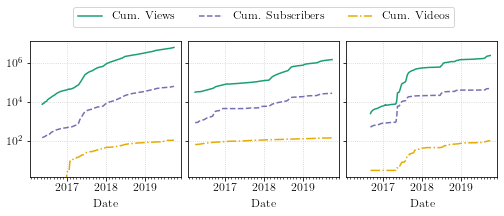

In [5]:
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
fig, axs = plt.subplots(1, 3, figsize=(7, 2.5), sharey=True, sharex=True, gridspec_kw={"wspace": 0.05,})
np.random.seed(5)
s = df_sb_f.sample(3).channel.values
for chan, ax in zip(s, axs):
    vals = df_sb_f.loc[df_sb_f.channel == chan]
    vals.datetime = pd.to_datetime(vals.datetime)
    ax.plot(vals.datetime, vals.views, label="Cum. Views", color="#1b9e77")
    ax.plot(vals.datetime, vals.subs, label="Cum. Subscribers", color="#7570b3", ls="--")
    ax.plot(vals.datetime, vals.videos, label="Cum. Videos", color="#e6ab02", ls="-.")
    ax.set_yscale('log')
    ax.set_xlabel("Date")
    ax.xaxis.grid(color="#CCCCCC", ls=":")
    ax.yaxis.grid(color="#CCCCCC", ls=":")

axs[1].legend(bbox_to_anchor=(0.5, 1.3), ncol=3, loc='upper center')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

set_size(fig, size=(7, 3))
fig.savefig("./images/example_ts.pdf", bbox_inches="tight")

## 3. Time series completeness

In [6]:
df_sb_sum = df_sb_f.groupby(pd.Grouper(key="datetime", freq="M")).agg({"channel": pd.Series.nunique})
df_sb_sum = df_sb_sum.head(-1)

In [7]:
df_ch_sum = df_ch_f.groupby(pd.Grouper(key="join_date", freq="M")).channel.count()
df_ch_sum = df_ch_sum.cumsum()
df_ch_sum = df_ch_sum[df_sb_sum.index]

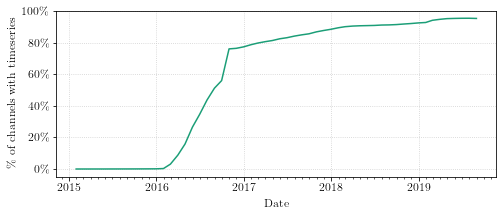

In [8]:
fig, ax = plt.subplots(1, figsize=(7,3), sharey=True, sharex=True,
                       gridspec_kw={"wspace": 0.05})
ax.plot(df_sb_sum.channel /df_ch_sum, color="#1b9e77")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.xaxis.grid(color="#CCCCCC", ls=":")
ax.yaxis.grid(color="#CCCCCC", ls=":")
ax.set_xlabel("Date")
ax.set_ylabel("\% of channels with timeseries")
set_size(fig, size=(7, 3))
fig.savefig("./images/repr_ts.pdf", bbox_inches="tight")

## 3.  Creation date for channels and videos

In [9]:
df_ch_count = df_ch_f.groupby(pd.Grouper(key="join_date", freq="M")).count().videos_cc
df_vc_count = df_vd_f.groupby(pd.Grouper(key="upload_date", freq="M")).count().channel_id

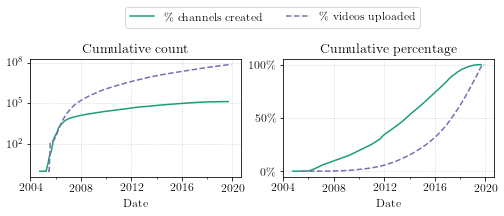

In [10]:
years = mdates.YearLocator(4)   # every 2 years
months = mdates.YearLocator(2)  # every year
fig, axs = plt.subplots(1, 2, figsize=(7,3), sharex=True, gridspec_kw={"wspace": 0.20})

ax = axs[0]
ax.plot(df_ch_count.cumsum(),  color="#1b9e77", label="\% channels created")
ax.plot(df_vc_count.cumsum(),  color="#7570b3", ls="--", label="\% videos uploaded")
ax.set_yscale("log")
ax.set_title("Cumulative count")
ax = axs[1]
ax.plot(df_ch_count.cumsum()/136470,  color="#1b9e77", label="\% channels created")
ax.plot(df_vc_count.cumsum()/72924794,  color="#7570b3", ls="--", label="\% videos uploaded")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_title("Cumulative percentage")

for ax in axs:
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.grid(color="#CCCCCC", ls=":")
    ax.yaxis.grid(color="#CCCCCC", ls=":")
    ax.set_xlabel("Date")

axs[0].legend(bbox_to_anchor=(1.15, 1.5), ncol=3, loc='upper center')
set_size(fig, size=(7, 3))
fig.savefig("./images/overall_ch.pdf", bbox_inches="tight")

## 4. Ranking completeness

SpearmanrResult(correlation=-0.9937211072304837, pvalue=0.0)


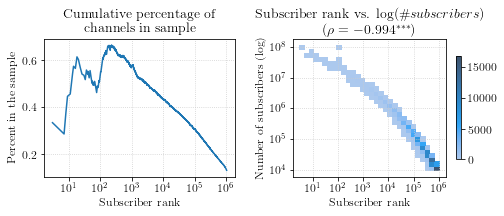

In [11]:
import scipy.stats as stats
fig, axs = plt.subplots(1, 2, figsize=(14, 3), sharex=True, gridspec_kw={"wspace": 0.30})
 

ax = axs[0]

ranks = df_ch_f["subscriber_rank_sb"].dropna().sort_values().values
quant = np.array(list(range(1,len(ranks)+ 1)))
p = quant / ranks

ax.plot(ranks, p)#, s=10, alpha=1)
ax.set_xscale("log")
ax.set_ylabel("Percent in the sample")
ax.set_xlabel("Subscriber rank")
ax.set_title("Cumulative percentage of\nchannels in sample")
ax.xaxis.grid(color="#CCCCCC", ls=":")
ax.yaxis.grid(color="#CCCCCC", ls=":")
ax.set_xticks([10**1, 10**2, 10**3, 10**4, 10**5, 10**6])

ax = axs[1]
sns.histplot(
    df_ch_f, x="subscriber_rank_sb", y="subscribers_cc",
    bins=30, discrete=(False, False), log_scale=(True, True),
    cbar=True, cbar_kws=dict(shrink=.75),
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Subscriber rank")
ax.set_ylabel("Number of subscribers ($\log$)")
ax.xaxis.grid(color="#CCCCCC", ls=":")
ax.yaxis.grid(color="#CCCCCC", ls=":")
ax.set_title(r'Subscriber rank vs. $\log(\#subscribers)$' + "\n" + r'($\rho = -0.994^{***}$)')
print(stats.spearmanr(df_ch_f[~df_ch_f["subscriber_rank_sb"].isna()]["subscriber_rank_sb"], 
                df_ch_f[~df_ch_f["subscriber_rank_sb"].isna()]["subscribers_cc"]))
ax.set_yticks([10**4, 10**5, 10**6, 10**7, 10**8])
ax.set_xticks([10**1, 10**2, 10**3, 10**4, 10**5, 10**6])

set_size(fig, size=(7, 3))
fig.savefig("./images/ranking.pdf", bbox_inches="tight")

## Table 1: Views, Videos, Likes, Duration

In [12]:
df_vd_cat_count = df_vd_f.groupby("categories").sum()
df_vd_cat_count = df_vd_cat_count.drop(["", "Movies", "Shows"])
df_vd_cat_count[["dislike_count", "like_count"]] = df_vd_cat_count[["dislike_count", "like_count"]] / 1000000
df_vd_cat_count[["dummmy"]] = df_vd_cat_count[["dummmy"]] / 1000000
df_vd_cat_count[["view_count"]] = df_vd_cat_count[["view_count"]] / 1000000000
df_vd_cat_count[["duration"]] = df_vd_cat_count[["duration"]] / 3.154e+7
tmp = df_vd_cat_count.rename({"dislike_count": "# Dislikes (M)",
    "duration": "Duration (Years)",
    "like_count": "# Likes (M)",
    "view_count": "# Views (B)",
    "dummmy": "# Videos (M)"
    }, axis=1)[["# Views (B)", "# Videos (M)", "# Likes (M)", "Duration (Years)"]]
tmp = tmp.append(tmp.sum(axis=0).rename("Total"))
print(round(tmp,1).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  \# Views (B) &  \# Videos (M) &  \# Likes (M) &  Duration (Years) \\
categories            &              &               &              &                   \\
\midrule
Autos \& Vehicles      &        123.1 &           2.3 &        956.3 &              27.0 \\
Comedy                &        345.0 &           1.2 &       6134.2 &              18.9 \\
Education             &        502.4 &           3.8 &       2881.4 &             117.1 \\
Entertainment         &       2287.7 &          12.3 &      20140.6 &             243.1 \\
Film \& Animation      &        576.3 &           2.4 &       3737.8 &              47.7 \\
Gaming                &       1042.5 &          13.7 &      17351.3 &             623.2 \\
Howto \& Style         &        420.7 &           4.0 &       5790.8 &              73.6 \\
Music                 &       2475.0 &           8.3 &      19270.5 &             124.1 \\
News \& Politics       &        158.6 &           8.9 &       

## Extra 1: Missing data on time-series data!

0.7640485542856194

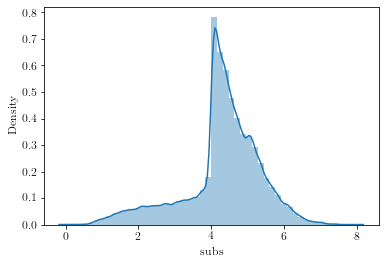

In [13]:
sns.distplot(np.log10(df_sb_f[(df_sb_f.delta_subs == 0)].subs))
np.mean((df_sb_f[(df_sb_f.delta_subs == 0)].subs > 9900) & (df_sb_f[(df_sb_f.delta_subs == 0)].subs > 10100))

## Extra 2:  Completeness of # videos

Text(0.5, 1.0, 'Completeness of videos per channel')

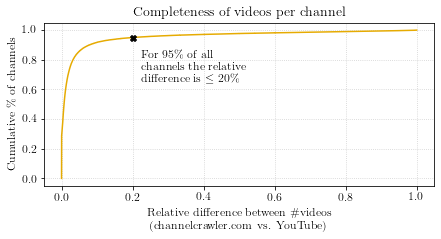

In [14]:
import scipy.stats as stats
fig, ax = plt.subplots(1, 1, figsize=(7, 3), sharex=False, gridspec_kw={"wspace": 0.30})
x = abs(df_ch_f["videos_yt"] - df_ch_f["videos_cc"]) / pd.concat([df_ch_f["videos_yt"], 
                                                                  df_ch_f["videos_cc"]], axis=1).max(axis=1)


x = sorted(x)
p = 1. * np.arange(len(x))/(len(x) - 1)
p95 = abs(p - 0.95).argmin()
ax.plot(x, p, color="#e6ab02")
ax.scatter([x[p95]], [p[p95]], zorder=10, color="black", marker="X")
ax.text(x[p95] + 0.025, p[p95] -0.0825, 
        "For 95\% of all \n channels the relative  \n difference is $\leq$ 20\%", va="top")
ax.xaxis.grid(color="#CCCCCC", ls=":")
ax.yaxis.grid(color="#CCCCCC", ls=":")
ax.set_ylabel("Cumulative \% of channels")
ax.set_xlabel(r'Relative difference between \#videos' + '\n(channelcrawler.com vs. YouTube)')
ax.set_title("Completeness of videos per channel")